# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[-15,-10,-5,0,5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[-15,-10,-5,0,5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/Synthetic\ Datasets/AutoML

Mounted at /gdrive
/gdrive/My Drive/Modulation-Classification/Synthetic Datasets/AutoML


### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# Importing Preprocessing Libraries
from Import_Functions import ImportData,ImportDatasets
from Plot_Results import EvaluateData, PlotResults

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.models import Model

     |████████████████████████████████| 174kB 8.0MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=82d3b0ee90162805c4de6f046dab3e251a6ad914137cd8f1cc35de676da2ace5
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=4320e51824d1d08b794f804a5605a2a5bf2ab89783d2440cf4e3f4b85c75e28b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## AutoML MLP Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(2,)$

### Importing Data and Creating Classifier

Importing Data

In [3]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

Creating a Classifier

In [4]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=3,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 3 Complete [00h 00m 16s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 54s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8255 - accuracy: 0.8052
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 1.0357 - accuracy: 0.5663
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.7957 - accuracy: 0.7158
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6633 - accuracy: 0.7613
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6272 - accuracy: 0.7394
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5858 - accuracy: 0.7429
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5748 - accuracy: 0.7434
Epoch 8/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5711 - accuracy: 0.7446
Epoch 9/15
469/469 [==============================

Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

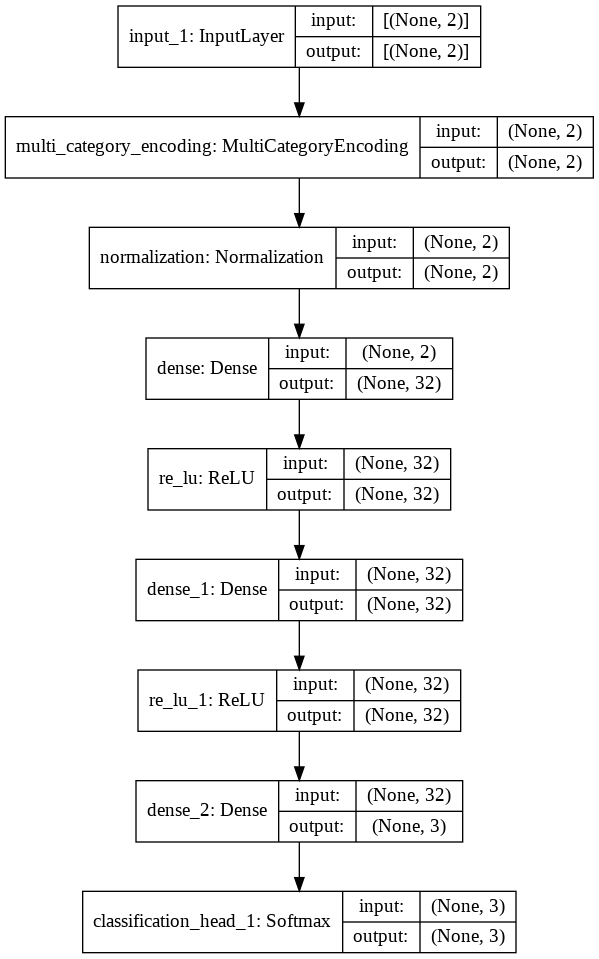

In [5]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model_MLP.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [6]:
AWGN_Model.fit(X_Train, y_Train, epochs=100, batch_size=512, validation_split=0.1,shuffle=True)

Epoch 1/100
53/53 [==============================] - 1s 6ms/step - loss: 1.0805 - accuracy: 0.4242 - val_loss: 0.4056 - val_accuracy: 0.8110
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.8924 - val_loss: 0.6052 - val_accuracy: 0.7413
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4059 - accuracy: 0.8480 - val_loss: 0.6032 - val_accuracy: 0.7413
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3909 - accuracy: 0.8452 - val_loss: 0.5975 - val_accuracy: 0.7413
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.8497 - val_loss: 0.5942 - val_accuracy: 0.7413
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3637 - accuracy: 0.8583 - val_loss: 0.5883 - val_accuracy: 0.7413
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3489 - accuracy: 0.8702 - val_loss: 0.5723 - val_accuracy: 0.7413
Epoch 8/100
5

Evaluate the Model

Evaluating Model
SNR: -15 Accuracy: 0.3567333221435547
SNR: -10 Accuracy: 0.3978666663169861
SNR: -5 Accuracy: 0.48813334107398987
SNR: 0 Accuracy: 0.5807333588600159
SNR: 5 Accuracy: 0.6537666916847229
SNR: 10 Accuracy: 0.723800003528595
SNR: 15 Accuracy: 0.7956666946411133
SNR: 20 Accuracy: 0.871999979019165
SNR: 25 Accuracy: 0.9147666692733765
SNR: 30 Accuracy: 0.920366644859314


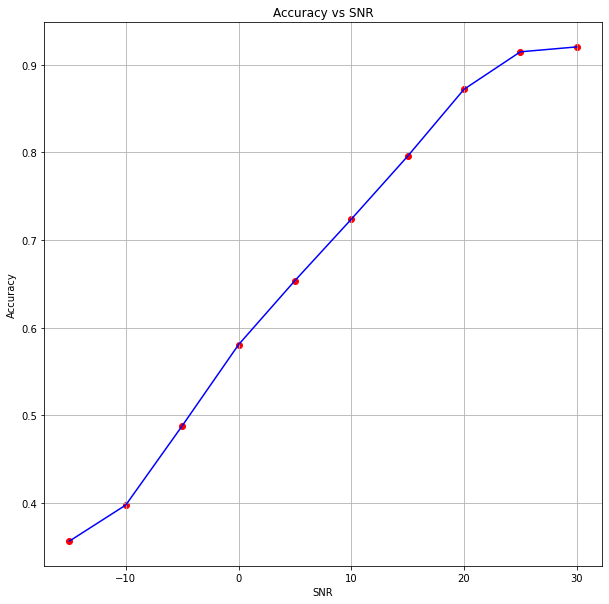

In [7]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy_MLP.jpg")

Save Model

In [8]:
AWGN_Model.save("../Models/AWGN_MLP.h5")

## AutoML CNN Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(100,2)$

### Importing Data and Creating Classifier

Importing Data

In [9]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

X_Train = X_Train.reshape(-1,100,2)
y_Train = y_Train[::100]
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = X_Valid[snr].reshape(-1,100,2)
    y_Valid[snr] = y_Valid[snr][::100]

Creating a Classifier

In [10]:
AWGNClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 1 Complete [00h 00m 32s]
val_loss: 0.4683837890625

Best val_loss So Far: 0.4683837890625
Total elapsed time: 00h 00m 32s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
5/5 [==============================] - 1s 36ms/step - loss: 1.3993 - accuracy: 0.2632
Epoch 2/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0071 - accuracy: 0.4805
Epoch 3/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0507 - accuracy: 0.1602
Epoch 4/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1442 - accuracy: 0.1476
Epoch 5/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1480 - accuracy: 0.1476
Epoch 6/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1049 - accuracy: 0.1476
Epoch 7/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0568 - accuracy: 0.1476
Epoch 8/15
5/5 [==============================] - 0s 5ms/step - loss: 1.0182 - accuracy: 0.1476
Epoch 9/15
5/5 [==============================] - 0s 5ms/step - l

Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

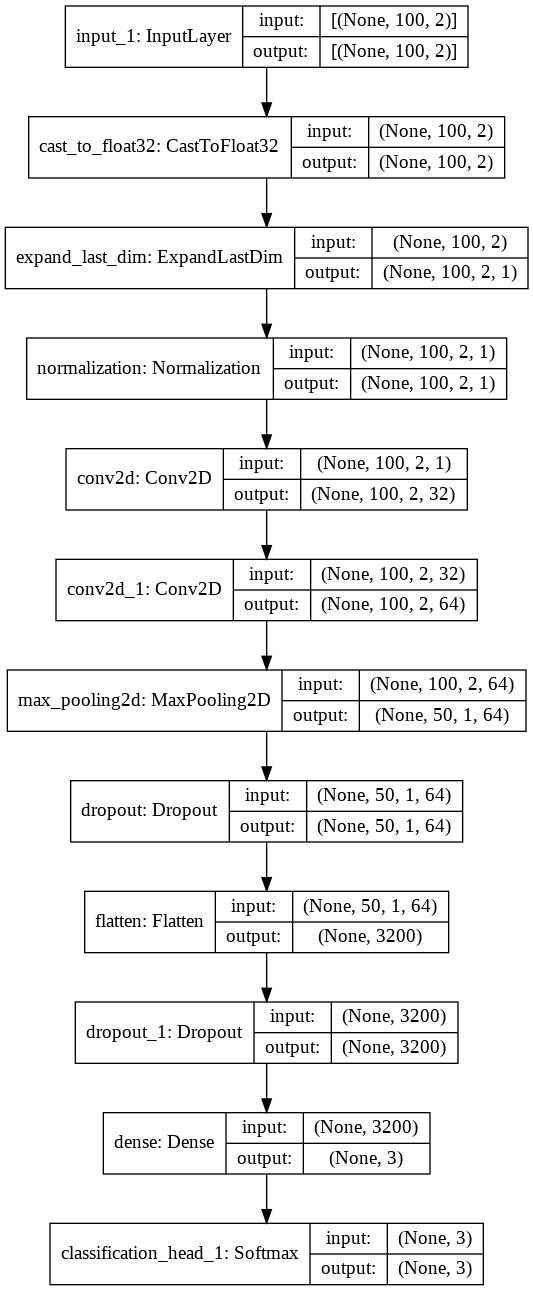

In [11]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model



In [12]:
AWGN_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.1,shuffle=True)

Epoch 1/25
17/17 [==============================] - 1s 21ms/step - loss: 0.7762 - accuracy: 0.7222 - val_loss: 0.2340 - val_accuracy: 1.0000
Epoch 2/25
17/17 [==============================] - 0s 5ms/step - loss: 0.6587 - accuracy: 0.8407 - val_loss: 0.2804 - val_accuracy: 1.0000
Epoch 3/25
17/17 [==============================] - 0s 5ms/step - loss: 0.4495 - accuracy: 0.9593 - val_loss: 0.1652 - val_accuracy: 1.0000
Epoch 4/25
17/17 [==============================] - 0s 4ms/step - loss: 0.1958 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 1.0000
Epoch 5/25
17/17 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.9963 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 6/25
17/17 [==============================] - 0s 5ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 7/25
17/17 [==============================] - 0s 5ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 8/25
17/17 [=

Evaluate the Model

Evaluating Model
SNR: -15 Accuracy: 0.3333333432674408
SNR: -10 Accuracy: 0.3333333432674408
SNR: -5 Accuracy: 0.6633333563804626
SNR: 0 Accuracy: 0.9666666388511658
SNR: 5 Accuracy: 1.0
SNR: 10 Accuracy: 1.0
SNR: 15 Accuracy: 1.0
SNR: 20 Accuracy: 1.0
SNR: 25 Accuracy: 1.0
SNR: 30 Accuracy: 1.0


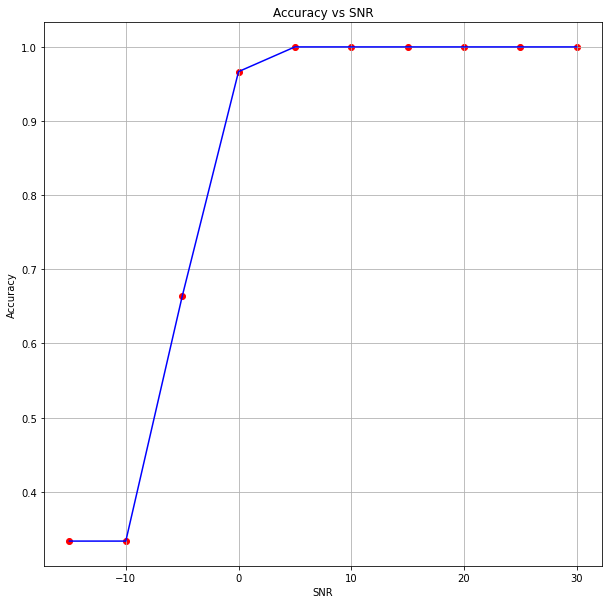

In [13]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy_CNN.jpg")

Save Model

In [14]:
AWGN_Model.save("../Models/AWGN_CNN.h5")

## AutoML CNN Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

### Importing Data and Creating Classifier


Importing Data

In [15]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

Creating a Classifier

In [16]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 15s]
val_loss: 7.741151785012335e-05

Best val_loss So Far: 7.741151785012335e-05
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2859 - accuracy: 0.9787
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.8068 - accuracy: 0.7539
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2783 - accuracy: 0.9000
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1582 - accuracy: 0.9556
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1561 - accuracy: 0.9578
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

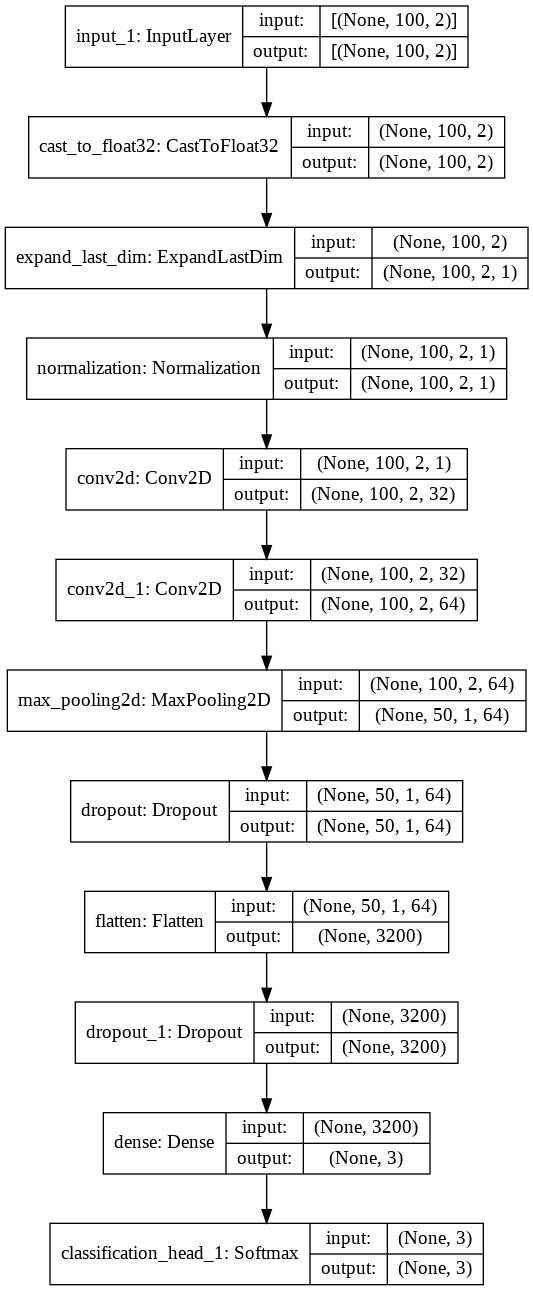

In [17]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=2_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [18]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1788 - accuracy: 0.9569 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 3.1247e-04 - accuracy: 1.0000 - val_loss: 6.2181e-05 - val_accuracy: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 3.2510e-05 - accuracy: 1.0000 - val_loss: 5.7821e-06 - val_accuracy: 1.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 1.5573e-05 - accuracy: 1.0000 - val_loss: 2.7264e-06 - val_accuracy: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 4ms/step - loss: 6.8088e-06 - accuracy: 1.0000 - val_loss: 1.6676e-06 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 4ms/step - loss: 6.7579e-06 - accuracy: 1.0000 - val_loss: 1.5645e-06 - val_accuracy: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 3.3239e-06 - accuracy: 1.0000 - va

Evaluate the Model

Evaluating Model
SNR: -15 Accuracy: 0.33526667952537537
SNR: -10 Accuracy: 0.6886000037193298
SNR: -5 Accuracy: 0.9945999979972839
SNR: 0 Accuracy: 0.9999333620071411
SNR: 5 Accuracy: 1.0
SNR: 10 Accuracy: 1.0
SNR: 15 Accuracy: 1.0
SNR: 20 Accuracy: 1.0
SNR: 25 Accuracy: 1.0
SNR: 30 Accuracy: 1.0


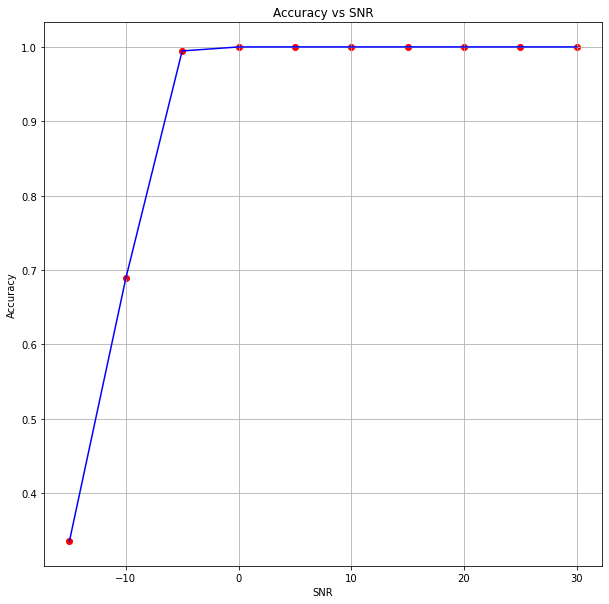

In [19]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=2_CNN.jpg")

Save Model

In [20]:
Rayleigh_Model.save("../Models/Rayleigh_L=2_CNN.h5")

## AutoML CNN Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

### Importing Data and Creating Classifier

Importing Classifier

In [21]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

Creating a Classifier

In [22]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 15s]
val_loss: 0.006995741277933121

Best val_loss So Far: 0.006995741277933121
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1371 - accuracy: 0.9773
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.9174 - accuracy: 0.4204
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4802 - accuracy: 0.8962
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4973 - accuracy: 0.9103
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5230 - accuracy: 0.8792
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

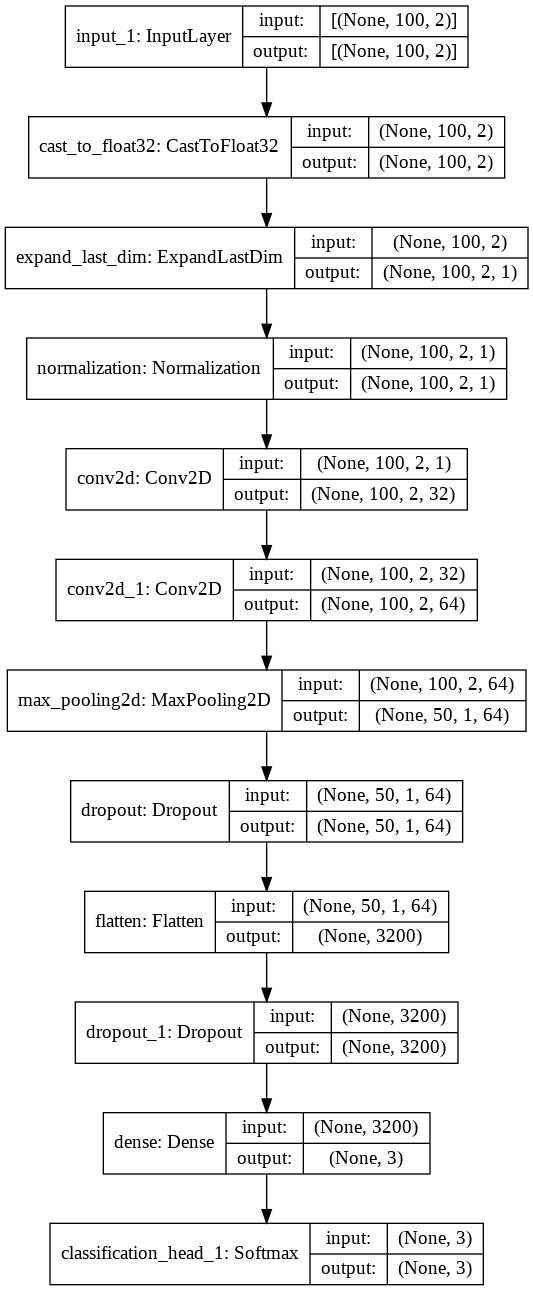

In [23]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=3_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [24]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.2284 - accuracy: 0.9301 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 2/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0178 - accuracy: 0.9937 - val_loss: 9.1165e-04 - val_accuracy: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 2.9905e-04 - val_accuracy: 1.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 1.9472e-04 - val_accuracy: 1.0000
Epoch 5/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 2.4586e-05 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 1.8624e-04 - val_accuracy: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 5.8720e-05 - val

Evaluate the Model

Evaluating Model
SNR: -15 Accuracy: 0.3333333432674408
SNR: -10 Accuracy: 0.3333333432674408
SNR: -5 Accuracy: 0.3333333432674408
SNR: 0 Accuracy: 0.6190000176429749
SNR: 5 Accuracy: 0.7979333400726318
SNR: 10 Accuracy: 0.9970666766166687
SNR: 15 Accuracy: 0.9999333620071411
SNR: 20 Accuracy: 1.0
SNR: 25 Accuracy: 0.9998666644096375
SNR: 30 Accuracy: 1.0


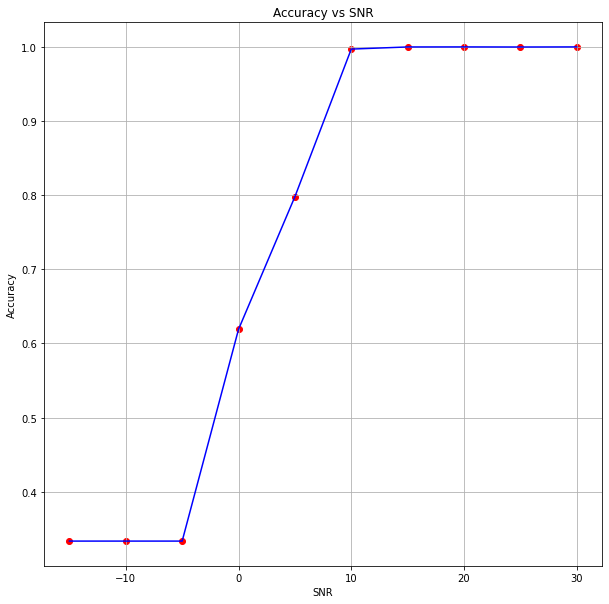

In [25]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=3_CNN.jpg")

Save Model

In [26]:
Rayleigh_Model.save("../Models/Rayleigh_L=3_CNN.h5")

## AutoML RNN Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

### Importing Data and Creating Classifier


Importing Data

In [27]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

Creating a Classifier

In [28]:
input_node = ak.Input()
rnn_node = ak.RNNBlock(return_sequences=True,
                       bidirectional=False,
                       num_layers=2,
                       layer_type='lstm')(input_node)
dense_node = ak.DenseBlock()(rnn_node)
output_node = ak.ClassificationHead(num_classes=3,
                                    loss='categorical_crossentropy')(dense_node)

RayleighClassifier = ak.AutoModel(inputs=input_node,
                                  outputs=output_node, 
                                  overwrite=True,
                                  max_trials=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 3 Complete [00h 00m 44s]
val_loss: 6.22095976723358e-05

Best val_loss So Far: 2.0044302800670266e-05
Total elapsed time: 00h 02m 12s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 11s 9ms/step - loss: 0.2421 - accuracy: 0.9810
Epoch 2/5
938/938 [==============================] - 8s 9ms/step - loss: 0.8059 - accuracy: 0.9020
Epoch 3/5
938/938 [==============================] - 8s 9ms/step - loss: 0.3125 - accuracy: 0.9395
Epoch 4/5
938/938 [==============================] - 8s 9ms/step - loss: 0.1804 - accuracy: 0.9336
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.1652 - accuracy: 0.9523


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 2)            40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 2)            40        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205824    
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0     

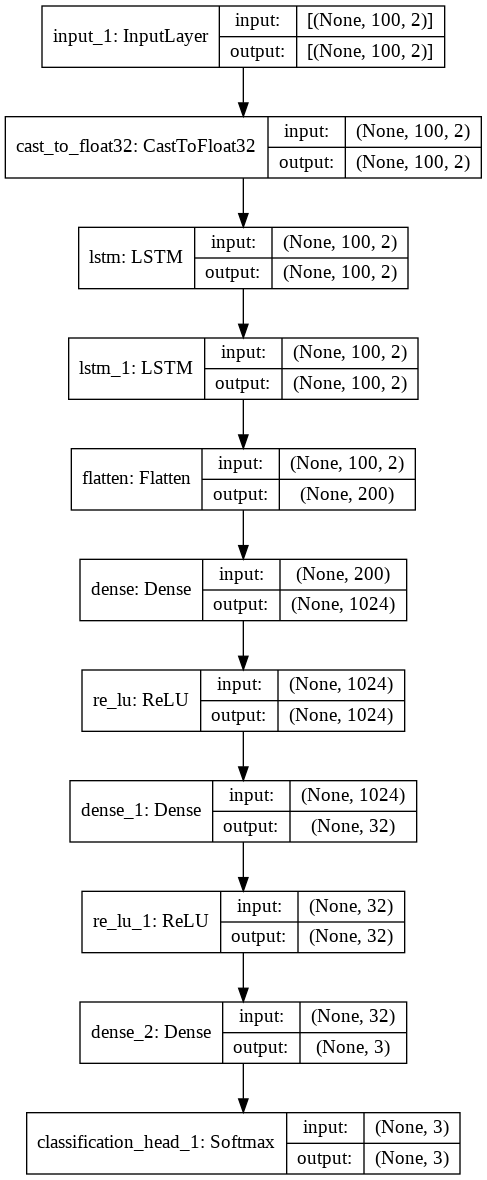

In [29]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=2_RNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [30]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 10s 11ms/step - loss: 0.1627 - accuracy: 0.9420 - val_loss: 0.0110 - val_accuracy: 0.9984
Epoch 2/25
704/704 [==============================] - 7s 10ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0029 - val_accuracy: 0.9997
Epoch 3/25
704/704 [==============================] - 7s 10ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0058 - val_accuracy: 0.9979
Epoch 4/25
704/704 [==============================] - 7s 10ms/step - loss: 6.0220e-04 - accuracy: 0.9999 - val_loss: 0.0031 - val_accuracy: 0.9989
Epoch 5/25
704/704 [==============================] - 7s 10ms/step - loss: 2.5064e-04 - accuracy: 0.9998 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 6/25
704/704 [==============================] - 7s 10ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0040 - val_accuracy: 0.9981
Epoch 7/25
704/704 [==============================] - 7s 10ms/step - loss: 4.8883e-05 - accuracy: 1.0000 - val_loss: 5.6138e-04 - val

Evaluate the Model

Evaluating Model
SNR: -15 Accuracy: 0.3333333432674408
SNR: -10 Accuracy: 0.34166666865348816
SNR: -5 Accuracy: 0.7497333288192749
SNR: 0 Accuracy: 0.9781333208084106
SNR: 5 Accuracy: 0.9980666637420654
SNR: 10 Accuracy: 0.9998000264167786
SNR: 15 Accuracy: 0.999666690826416
SNR: 20 Accuracy: 0.9995333552360535
SNR: 25 Accuracy: 0.999666690826416
SNR: 30 Accuracy: 1.0


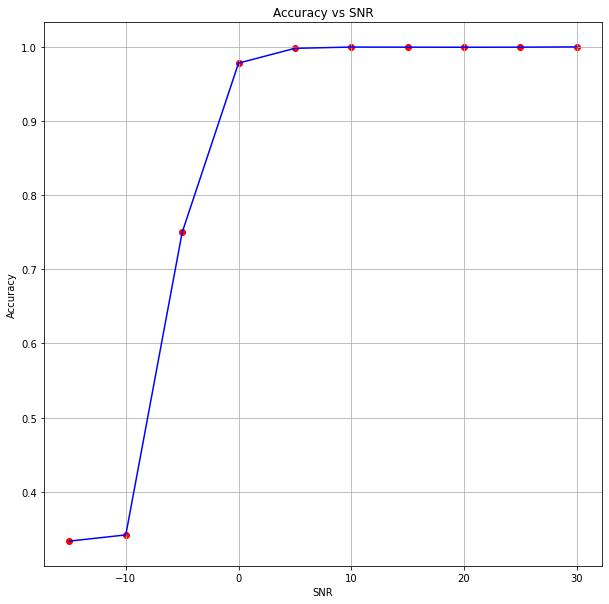

In [31]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=2_RNN.jpg")

Save Model

In [32]:
Rayleigh_Model.save("../Models/Rayleigh_L=2_RNN.h5")

## AutoML RNN Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

### Importing Data and Creating Classifier

Importing Data

In [33]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

Creating a Classifier

In [34]:
input_node = ak.Input()
rnn_node = ak.RNNBlock(return_sequences=True,
                       bidirectional=False,
                       num_layers=2,
                       layer_type='lstm')(input_node)
dense_node = ak.DenseBlock()(rnn_node)
output_node = ak.ClassificationHead(num_classes=3,
                                    loss='categorical_crossentropy')(dense_node)

RayleighClassifier = ak.AutoModel(inputs=input_node,
                                  outputs=output_node, 
                                  overwrite=True,
                                  max_trials=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 3 Complete [00h 00m 44s]
val_loss: 5.356362819952665e-08

Best val_loss So Far: 5.356362819952665e-08
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/5
938/938 [==============================] - 11s 9ms/step - loss: 0.3509 - accuracy: 0.9513
Epoch 2/5
938/938 [==============================] - 8s 9ms/step - loss: 1.0629 - accuracy: 0.6942
Epoch 3/5
938/938 [==============================] - 8s 9ms/step - loss: 0.9885 - accuracy: 0.7005
Epoch 4/5
938/938 [==============================] - 8s 9ms/step - loss: 0.8625 - accuracy: 0.7020
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.7691 - accuracy: 0.7403


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 2)            40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 2)            40        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0     

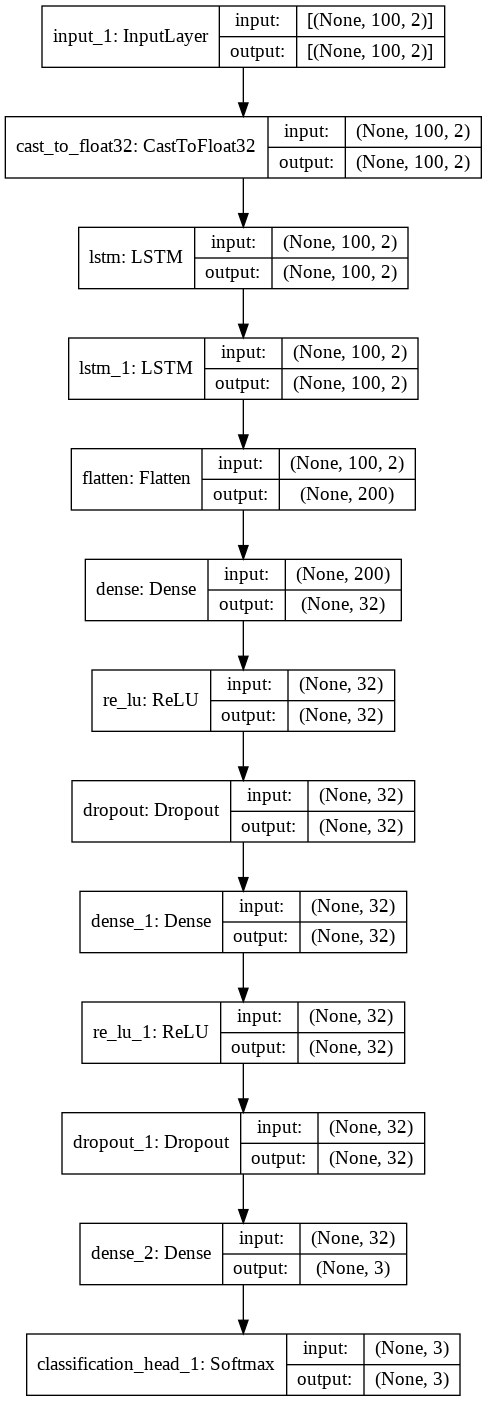

In [35]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=3_RNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [36]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 11s 11ms/step - loss: 0.8170 - accuracy: 0.5614 - val_loss: 0.1330 - val_accuracy: 0.9605
Epoch 2/25
704/704 [==============================] - 7s 10ms/step - loss: 0.6365 - accuracy: 0.6234 - val_loss: 0.2102 - val_accuracy: 0.9440
Epoch 3/25
704/704 [==============================] - 7s 11ms/step - loss: 0.5810 - accuracy: 0.6920 - val_loss: 0.1455 - val_accuracy: 0.9605
Epoch 4/25
704/704 [==============================] - 7s 10ms/step - loss: 0.5145 - accuracy: 0.7556 - val_loss: 0.0941 - val_accuracy: 0.9765
Epoch 5/25
704/704 [==============================] - 7s 10ms/step - loss: 0.4237 - accuracy: 0.8205 - val_loss: 0.0440 - val_accuracy: 0.9947
Epoch 6/25
704/704 [==============================] - 7s 10ms/step - loss: 0.3591 - accuracy: 0.8612 - val_loss: 0.1378 - val_accuracy: 0.9789
Epoch 7/25
704/704 [==============================] - 7s 10ms/step - loss: 0.3089 - accuracy: 0.8868 - val_loss: 0.3945 - val_accuracy: 0.965

Evaluate the Model

Evaluating Model
SNR: -15 Accuracy: 0.3333333432674408
SNR: -10 Accuracy: 0.33346667885780334
SNR: -5 Accuracy: 0.35366666316986084
SNR: 0 Accuracy: 0.5733333230018616
SNR: 5 Accuracy: 0.7323333621025085
SNR: 10 Accuracy: 0.9556000232696533
SNR: 15 Accuracy: 0.9827333092689514
SNR: 20 Accuracy: 0.9755333065986633
SNR: 25 Accuracy: 0.9675999879837036
SNR: 30 Accuracy: 0.968666672706604


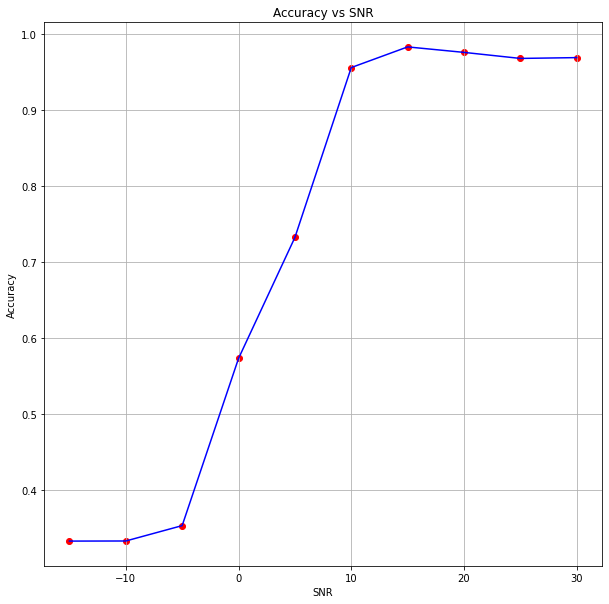

In [37]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=3_RNN.jpg")

Save Model

In [38]:
Rayleigh_Model.save("../Models/Rayleigh_L=3_RNN.h5")

## CNN Model for Rayleigh Data

This part of the code is written to verify the results with CNN.

### Creating a Model

In [39]:
def CreateCNNModel():
    tf.keras.backend.clear_session()
    In = Input(shape=(100,2))
    x = tf.keras.layers.Reshape((100,2,1))(In)
    x = Conv2D(filters=64,kernel_size=(3,1),activation='relu')(x)
    x = Conv2D(filters=16,kernel_size=(3,2),activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    Ou = Dense(3,activation='softmax')(x)

    model = Model(In,Ou)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["acc"])

    return model

### Rayleigh Fading of Channel Length = 2

Importing Data

In [40]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 100, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387   

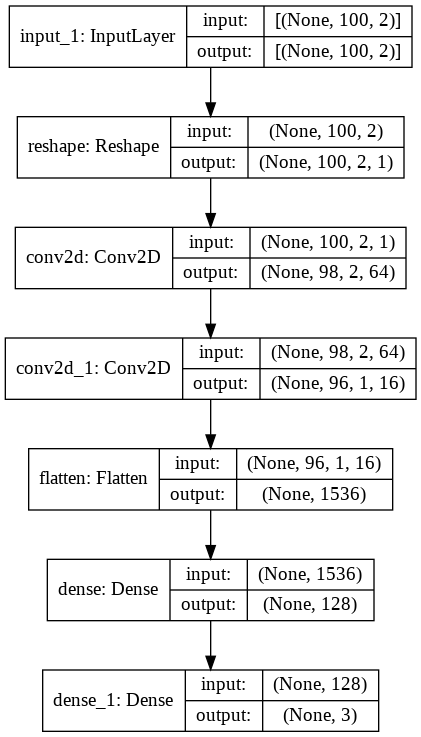

In [41]:
CNNModel = CreateCNNModel()
CNNModel.summary()
tf.keras.utils.plot_model(CNNModel, to_file='../Models/CNN_Rayleigh_Model_L=2.png', show_shapes=True,show_layer_names=True)

Training the Model

In [42]:
CNNModel.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1905 - acc: 0.8989 - val_loss: 1.8397e-04 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 4.1894e-05 - acc: 1.0000 - val_loss: 1.6784e-04 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 2s 4ms/step - loss: 1.2729e-05 - acc: 1.0000 - val_loss: 3.1486e-05 - val_acc: 1.0000
Epoch 4/25
704/704 [==============================] - 2s 4ms/step - loss: 5.9865e-06 - acc: 1.0000 - val_loss: 2.1242e-05 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 3s 4ms/step - loss: 3.0604e-06 - acc: 1.0000 - val_loss: 1.2252e-05 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 3s 4ms/step - loss: 1.8408e-06 - acc: 1.0000 - val_loss: 6.5739e-06 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 1.1102e-06 - acc: 1.0000 - val_loss: 5.6962e-06 - val_acc: 1.0000
Epoch 8/25
704/704 [====

Evaluating the Model

Evaluating Model
SNR: -15 Accuracy: 0.4397999942302704
SNR: -10 Accuracy: 0.5480666756629944
SNR: -5 Accuracy: 0.9345999956130981
SNR: 0 Accuracy: 0.9974666833877563
SNR: 5 Accuracy: 1.0
SNR: 10 Accuracy: 1.0
SNR: 15 Accuracy: 1.0
SNR: 20 Accuracy: 1.0
SNR: 25 Accuracy: 1.0
SNR: 30 Accuracy: 1.0


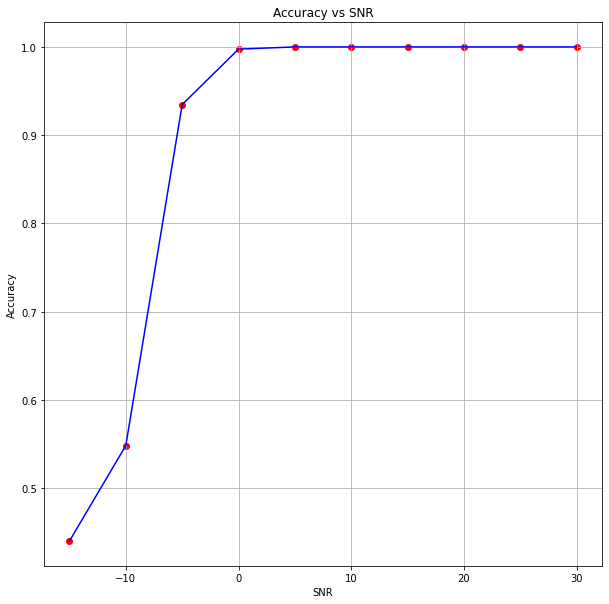

In [43]:
EvaluateData(CNNModel, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=2.jpg")

Save Model

In [44]:
CNNModel.save("../Models/CNN_Rayleigh_L=2.h5")

### Rayleigh Fading of Channel Length = 3

Importing Data

In [45]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 100, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387   

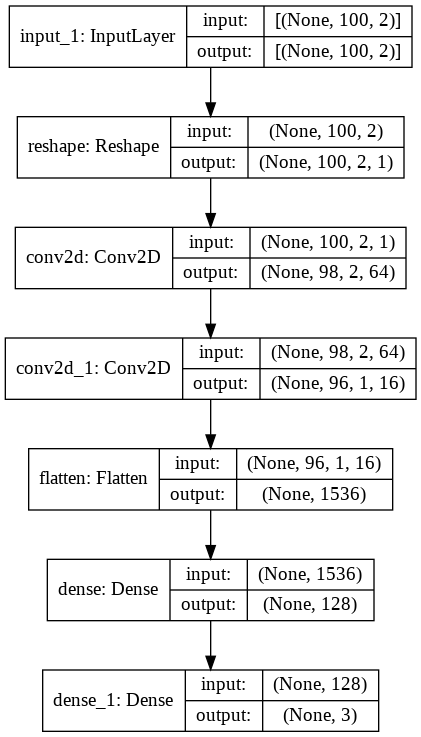

In [46]:
CNNModel = CreateCNNModel()
CNNModel.summary()
tf.keras.utils.plot_model(CNNModel, to_file='../Models/CNN_Rayleigh_Model_L=2.png', show_shapes=True,show_layer_names=True)

Training the Model

In [47]:
CNNModel.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.3082 - acc: 0.8510 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0091 - acc: 0.9970 - val_loss: 0.0012 - val_acc: 0.9997
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0127 - acc: 0.9953 - val_loss: 2.5406e-04 - val_acc: 1.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0094 - acc: 0.9970 - val_loss: 9.6261e-05 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0013 - acc: 0.9999 - val_loss: 1.3147e-04 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0050 - acc: 0.9983 - val_loss: 1.9345e-04 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0034 - acc: 0.9986 - val_loss: 8.1984e-05 - val_acc: 1.0000
Epoch 8/25
704/704 [==============================] - 3s

Evaluating the Model

Evaluating Model
SNR: -15 Accuracy: 0.3386666774749756
SNR: -10 Accuracy: 0.35740000009536743
SNR: -5 Accuracy: 0.4727333188056946
SNR: 0 Accuracy: 0.8889999985694885
SNR: 5 Accuracy: 0.9654666781425476
SNR: 10 Accuracy: 0.9890000224113464
SNR: 15 Accuracy: 0.9972666501998901
SNR: 20 Accuracy: 0.998199999332428
SNR: 25 Accuracy: 0.9991999864578247
SNR: 30 Accuracy: 1.0


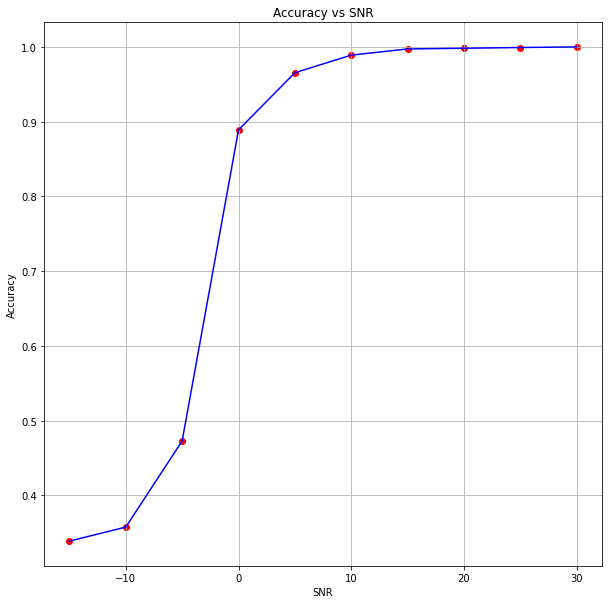

In [48]:
EvaluateData(CNNModel, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=3.jpg")

Save Model

In [49]:
CNNModel.save("../Models/CNN_Rayleigh_L=3.h5")

## Plot Results

### AWGN Models

Importing Data and Models

In [50]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

AWGN_MLP = tf.keras.models.load_model("../Models/AWGN_MLP.h5")
AWGN_CNN = tf.keras.models.load_model("../Models/AWGN_CNN.h5")

Plotting Results

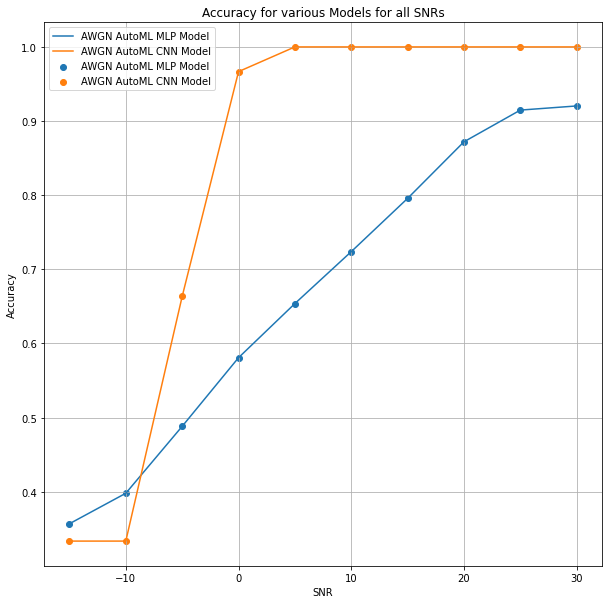

In [51]:
Models = {"AWGN AutoML MLP Model":AWGN_MLP, "AWGN AutoML CNN Model":AWGN_CNN}
PlotResults(Models, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracies.jpg")

### Rayleigh Models for L = 2


In [52]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

Rayeligh_AutoMLCNN = tf.keras.models.load_model("../Models/Rayleigh_L=2_CNN.h5")
Rayeligh_AutoMLRNN = tf.keras.models.load_model("../Models/Rayleigh_L=2_RNN.h5")
Rayeligh_CNN = tf.keras.models.load_model("../Models/CNN_Rayleigh_L=2.h5")

Plotting Results

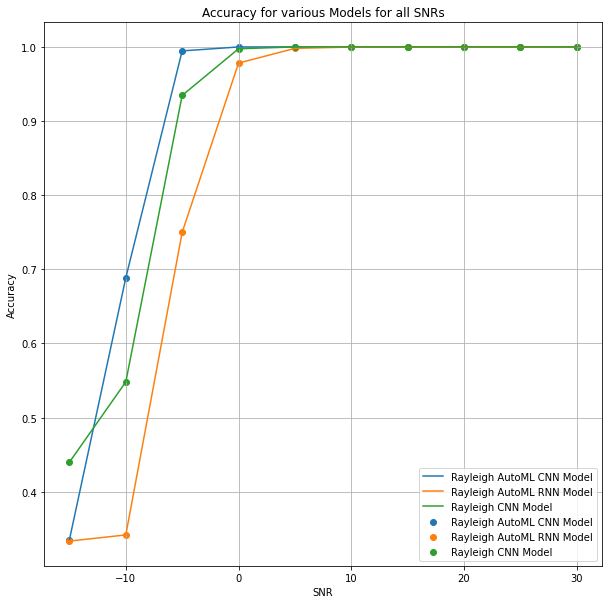

In [53]:
Models = {"Rayleigh AutoML CNN Model":Rayeligh_AutoMLCNN, "Rayleigh AutoML RNN Model":Rayeligh_AutoMLRNN, "Rayleigh CNN Model":Rayeligh_CNN}
PlotResults(Models, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_L=2_Accuracies.jpg")

### Rayleigh Models for L = 3


In [54]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

Rayeligh_AutoMLCNN = tf.keras.models.load_model("../Models/Rayleigh_L=3_CNN.h5")
Rayeligh_AutoMLRNN = tf.keras.models.load_model("../Models/Rayleigh_L=3_RNN.h5")
Rayeligh_CNN = tf.keras.models.load_model("../Models/CNN_Rayleigh_L=3.h5")

Plotting Results

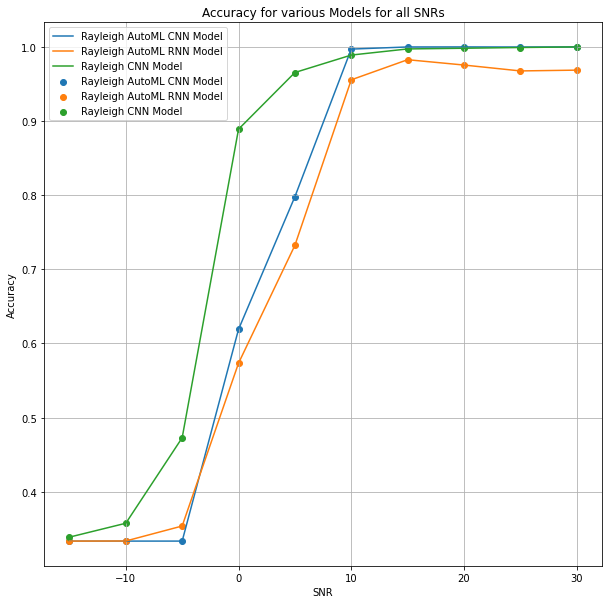

In [55]:
Models = {"Rayleigh AutoML CNN Model":Rayeligh_AutoMLCNN, "Rayleigh AutoML RNN Model":Rayeligh_AutoMLRNN, "Rayleigh CNN Model":Rayeligh_CNN}
PlotResults(Models, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_L=3_Accuracies.jpg")